# thal2 3:2 2k Bifurcation Diagrams

# Inits

## Imports

In [1]:
import sys; sys.path.insert(0, '..') # add parent folder path where lib folder is
# user-defined
import nmCoupling as nm
# import nmCoupling_old as nm
import response as rp

import thal2 as t2

from lib.util import (get_phase, freq_est,follow_phase_diffs,follow_phase_diffs_del,
                        follow_phase_diffs_u,follow_phase_diffs_u_del,
get_smallest_eps,get_largest_eps, get_es_min, get_es_max)

from lib.rhs import _redu_c2,_full, _redu_full, _full, _full_mono_rhs

from lib.plot_util import (add_diagram_1d_scatter, quick_plot_combined, 
                            draw_quick_plot_f, add_diagram_1d_del_scatter)


import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import sympy as sym

from scipy.signal import find_peaks
from scipy.optimize import root,bisect
from copy import deepcopy
import os

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Helvetica"
})

nmc = nm.nmCoupling
rsp = rp.Response

## Dicts

In [2]:
kw_sim = {'rtol':1e-9,'atol':1e-9,'method':'LSODA'}

In [3]:
pd1 = {'gL':0.05,'gna':3,'gk':5,
       'gt':5,'eL':-70,'ena':50,
       'ek':-90,'et':0,'esyn':0,
       'c':1,'alpha':3,'beta':2,
       'sigmat':0.8,'vt':-20,
       'ib':8.5,'del':0,'om':1,'om_fix':1}

In [4]:
# default period must be 2*np.pi
kws1 = {'var_names':['v','h','r','w'],
        'pardict':pd1,
        'rhs':t2.rhs,
        'coupling':t2.coupling,
        'init':np.array([-.64,0.71,0.25,0,6]),
        'TN':20000,
        'trunc_order':1,
        'z_forward':False,
        'i_forward':[False,True,False,False,False,False],
        'i_bad_dx':[False,True,False,False,False,False],
        'max_iter':50,
        'rtol':1e-12,
        'atol':1e-12,
        'rel_tol':1e-9,
        'save_fig':False,
        'lc_prominence':.05,
        'factor':1}

## Defs

In [5]:
#### es_min,phi0 = get_es_min(data_bs_list,data_bu_list)
def get_monodromy_full(es_min,phi0,a,b,mname='',tol=1e-6,recompute=False):
    """
    es_min: minimum epsilon to use
    a: nmCoupling object
    b: het. parameter.
    mnamei are the model names to save the monodromy matrix and related calculations
    """    

    kw_b = {'a':a,'b':b,'recompute':recompute,'bifdir':'bif1d_thal2/','_full_rhs':_full}
    print('es_min,phi0',es_min,phi0)
    # the _u function has the ability to save and load Y values
    _,Y = follow_phase_diffs(**dict(phi0=phi0,eps_init=es_min,eps_final=es_min-.01,deps=-1),max_time=10000,tol=tol,return_point=True,**kw_b)

    print('Y',Y)
    # define parameters for finding monodromy of full system
    pd_vdp_thal = {**a.system1.pardict,**a.system2.pardict}
    pd_vdp_thal['b']=b
    pd_vdp_thal['a']=a
    
    pd_vdp_thal['eps']=es_min
    # print(pd1['del0'])
    
    # default period must be 2*np.pi
    kws_vdp_thal = {'var_names':['v0','h0','r0','w0','v1','h1','r1','w1'],
                    'pardict':pd_vdp_thal,
                    'rhs':_full_mono_rhs,
                    'coupling':lambda x: 0*x,
                    'init':Y, # from above
                    'use_init':True, # use init for direct LC calculation
                    'TN':50000,
                    'mode':'none', # forces not normalizing period.
                    'rtol_lc':1e-10,
                    'atol_lc':1e-10,
                    'trunc_order':0,
                    'z_forward':False,
                    'i_forward':False,
                    'i_bad_dx':[False,True,False,False,False,False],
                    'save_fig':False,
                    'max_iter':50,
                    'max_time_lc':5000,
                    'tol_root_lc':1e-8,
                    'halt_after_mono':True}

    m1 = rsp(idx='',model_name=mname,**kws_vdp_thal)

    return m1

In [6]:
kw_bif = {'method':'LSODA','dense_output':True,'rtol':1e-9,'atol':1e-9}

In [7]:
x_temp = np.linspace(-np.pi,3*np.pi,500)

In [8]:
ss,dss=np.linspace(0,2,100,retstep=True)

In [9]:
def compute_sol_all(a,eps,phi0,b,T=2000,dt=.01):
    """
    only for use in jupyter
    """
    t = np.arange(0,T,dt)
    args = {'args':(a,eps,b), 't_eval':t,**kw_sim}

    y0a = a.system1.lc['dat'][int((phi0/(2*np.pi)) * a.system1.TN),:]
    y0b = a.system2.lc['dat'][int((0/(2*np.pi)) * a.system2.TN),:]
    y0 = np.array([y0a,y0b]).flatten()
    #a.system1.pardict['del0'] = b

    tot = 0
    for i in range(len(a.het_coeffs)):
        tot += eps**i*b**(i+1)*a.het_coeffs[i]
    a.system1.pardict['del0'] = tot
    print(a.system1.pardict['del0'])
    #print(pd1['del0'])
    
    solf = solve_ivp(_full,[0,t[-1]], y0, **args)

    args['args'] = (a,eps,b,1)
    solr_o1 = solve_ivp(_redu_c2,[0,t[-1]], [phi0],**args)
    
    args['args'] = (a,eps,b,2)
    solr_o2 = solve_ivp(_redu_c2,[0,t[-1]], [phi0],**args)
    
    #args['args'] = (a,eps,b,3)
    #solr_o3 = solve_ivp(_redu_c2,[0,t[-1]], [phi0],**args)
    
    #args['args'] = (a,eps,b,4)
    #solr_o4 = solve_ivp(_redu_c2,[0,t[-1]], [phi0],**args)

    return solf, solr_o1, solr_o2#, solr_o3, solr_o4


def load_sol_all(a,eps,phi0,b,T,dt=.01,path_loc='sols_temp/',recompute=True):
    if (not os.path.exists(path_loc)):
        os.makedirs(path_loc)
    
    fname_f = 'sol_f_thal2_nm={}{}_eps={}_b={}_T={}_phi0={}.dat'.format(a._n[1],a._m[1],eps,b,T,phi0)
    fname_r = 'sol_r_thal2_nm={}{}_eps={}_b={}_T={}_phi0={}.dat'.format(a._n[1],a._m[1],eps,b,T,phi0)

    fname_f = path_loc + fname_f
    fname_r = path_loc + fname_r

    print('full',fname_f)
    print('redu',fname_r)
    
    file_dne = not(os.path.isfile(fname_f))
    file_dne += not(os.path.isfile(fname_r))

    if file_dne or recompute:
        solf, solr_o1, solr_o2 = compute_sol_all(a,eps,phi0,b,T=T,dt=dt)

        # phase of full model
        ta, pha = get_phase(solf.t,solf.y.T[:,:4], skipn=200,system1=a.system1)
        tb, phb = get_phase(solf.t,solf.y.T[:,4:], skipn=200,system1=a.system2)

        dat1 = np.zeros([len(ta),2])
        dat1[:,0] = ta
        dat1[:,1] = np.mod(pha - a.om*phb,2*np.pi)

        dat2 = np.zeros([len(solr_o1.t),5])
        dat2[:,0] = solr_o1.t
        dat2[:,1] = solr_o1.y[0]
        dat2[:,2] = solr_o2.y[0]

        np.savetxt(fname_f,dat1)
        np.savetxt(fname_r,dat2)

    else:
        dat1 = np.loadtxt(fname_f)
        dat2 = np.loadtxt(fname_r)
    return dat1, dat2

## Initialize Response Functions

In [10]:
system1 = rsp(idx=0,model_name='thal0_85_2k',**kws1)
system2 = rsp(idx=1,model_name='thal1_85_2k',**kws1)

mkdir ./data/thal0_85_2k/
* Loading LC data...
self.T 6.283185307179586 omfix 0.990198152249508
self.T 6.283185307179586
loaded coupling expansions
* Loading monodromy...
* Floquet Exponent kappa = -0.02435447577890923
* Loading g symbolic...
* Computing g...
* Loading heterogeneous terms...
* Computing z...
* Computing i...
mkdir ./data/thal1_85_2k/
* Loading LC data...
self.T 6.283185307179586 omfix 0.990198152249508
self.T 6.283185307179586
loaded coupling expansions
* Loading monodromy...
* Floquet Exponent kappa = -0.02435447577890923
* Loading g symbolic...
* Computing g...
* Loading heterogeneous terms...
* Computing z...
* Computing i...


# Initialize Coupling 3:2

In [11]:
het_coeffs = [1,2000]

In [12]:
#recompute_list = ['k_thal0_85','k_thal1_85','h_thal0_85','h_thal1_85', 'h_data_thal0_85','h_data_thal1_85', 'p_data_thal0_85','p_data_thal1_85','p_thal0_85','p_thal1_85']
# recompute_list = ['k_thal0_85','k_thal1_85']
nm_tup = (3,2)
recompute_list = []
kw_nm = {'system1':system1,'system2':system2,'_n':('om0',nm_tup[0]),'_m':('om1',nm_tup[1]),
         'NH':1024,'save_fig':False, 'recompute_list':recompute_list,
         'het_coeffs':het_coeffs, # [eps, eps^2, etc]
        }
a = nm.nmCoupling(**kw_nm)
nm_val = str(nm_tup[0])+str(nm_tup[1])

Initializing 32 Coupling...
pfactor 30
* Loading p symbolic...
* Loading p symbolic...
p order=0
p order=0
* Loading H symbolic...
* Loading H symbolic...
* Loading H thal0_85_2k, order=0...
* Loading H thal1_85_2k, order=0...
* Loading H thal0_85_2k, order=1...
* Loading H thal1_85_2k, order=1...


### Plot 1par eps

In [13]:
etup = (.001,.2,100)

In [14]:
# fig,axs = plt.subplots(1,2,figsize=(6,2))
# kw_diagram = dict(a=a,b=-0.04,eps_tup=etup,rhs=_redu_c2)
# add_diagram_1d_scatter(axs[0],miter=1,**kw_diagram)
# add_diagram_1d_scatter(axs[1],miter=2,**kw_diagram)

<Axes: >

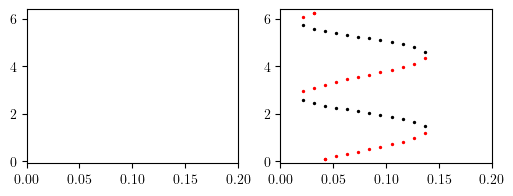

In [15]:
fig,axs = plt.subplots(1,2,figsize=(6,2))
kw_diagram = dict(a=a,b=-0.0063,eps_tup=(0,.2,20),rhs=_redu_c2)
add_diagram_1d_scatter(axs[0],miter=1,**kw_diagram)
add_diagram_1d_scatter(axs[1],miter=2,**kw_diagram)

<Axes: >

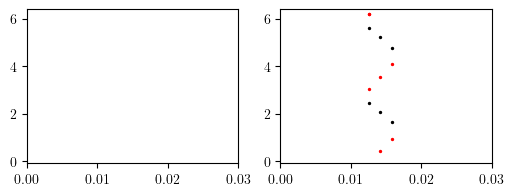

In [16]:
fig,axs = plt.subplots(1,2,figsize=(6,2))
kw_diagram = dict(a=a,b=-.035,eps_tup=(0,.03,20),rhs=_redu_c2)
add_diagram_1d_scatter(axs[0],miter=1,**kw_diagram)
add_diagram_1d_scatter(axs[1],miter=2,**kw_diagram)

### Plot 1par del

<Axes: >

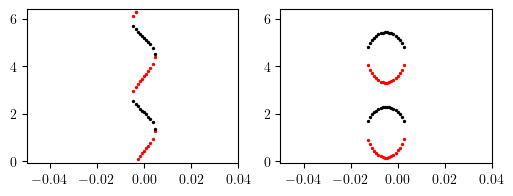

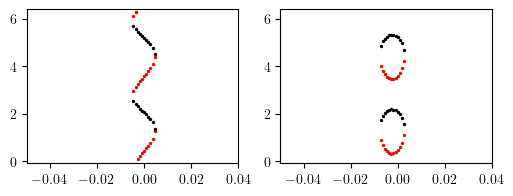

In [17]:
dtup12 = (-.05,.04,100)

fig,axs = plt.subplots(1,2,figsize=(6,2))
kw_diagram = dict(a=a,eps=0.05,del_tup=dtup12,rhs=_redu_c2)
add_diagram_1d_del_scatter(axs[0],miter=1,**kw_diagram)
add_diagram_1d_del_scatter(axs[1],miter=2,**kw_diagram)

fig,axs = plt.subplots(1,2,figsize=(6,2))
kw_diagram = dict(a=a,eps=0.1,del_tup=dtup12,rhs=_redu_c2)
add_diagram_1d_del_scatter(axs[0],miter=1,**kw_diagram)
add_diagram_1d_del_scatter(axs[1],miter=2,**kw_diagram)

#for i in range(4):
#    draw_quick_plot_f(axs[i],data_b1_list,a)

## EPS VARY

In [18]:
kw_b = {'a':a,'b':0,'recompute':False,'bifdir':'bif1d_thal2_2k/','_full_rhs':_full}
fname_bs = kw_b['bifdir']+'hyper_thal2_'+nm_val+'_b={}_s.txt'
fname_bu = kw_b['bifdir']+'hyper_thal2_'+nm_val+'_b={}_u.txt'

In [19]:
mname_list = ['thal2_'+nm_val+'_b'+str(i)+'={}' for i in range(5)]

In [20]:
b_vals_full = []
e_vals_full = [] # save min eps values for all diagrams
e_hi_full = [] # save max eps values for all diagrams

## monodromy calculations
e_vals_mono_min = [] # save eps values at min monodromy
eigenvalues_min_all = []
b_min_all = []

e_vals_mono_max = [] # save eps values at max monodromy
eigenvalues_max_all = []
b_max_all = []

### b=0.0025

#### Branches eps stable

In [21]:
b=.0025
kw_b['recompute'] = False
kw_b['b'] = b

In [22]:
# in_dicts = [dict(phi0=phi0,eps_init=0.1,eps_final=0,deps=-.01) for phi0 in np.linspace(0,2*np.pi,20)]
in_dicts = [dict(phi0=5,eps_init=0.1001,eps_final=0,deps=-.01),
            dict(phi0=5,eps_init=0.0999,eps_final=0.2,deps=.01)]

In [23]:
data_bs_list = []
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat = follow_phase_diffs(**in1,**kw_b)
    data_bs_list.append(dat)

phi init 5
phi init 5


In [24]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts),4])
for i in range(len(in_dicts)):
    hyp_inputs[i,0] = in_dicts[i]['phi0']
    hyp_inputs[i,1] = in_dicts[i]['eps_init']
    hyp_inputs[i,2] = in_dicts[i]['eps_final']
    hyp_inputs[i,3] = in_dicts[i]['deps']
np.savetxt(fname_bs.format(b),hyp_inputs)

#### Branches eps unstable

In [25]:
kw_b['recompute'] = False

In [26]:
kw_b['b'] = b

In [27]:
da,Yinit = follow_phase_diffs_u(**dict(phi0=4,eps_init=0.01,eps_final=0,deps=-2),return_point=True,**kw_b)
print(da)
da,Yinit = follow_phase_diffs_u(**dict(phi0=4,eps_init=0.02,eps_final=0,deps=-2),use_point=Yinit,return_point=True,**kw_b)
print(da)
da,Yinit = follow_phase_diffs_u(**dict(phi0=4,eps_init=0.03,eps_final=0,deps=-2),use_point=Yinit,return_point=True,**kw_b)
print(da)

phi init 4
phase_diffs_u_init=4_nm=32_b=0.0025_ei=0.01_ef=0_de=-2.txt
phase_diffs_u_pt_init=4_nm=32_b=0.0025_ei=0.01_ef=0_de=-2.txt
[0.01       2.08980842 2.08980842 3.88572528 0.7540544 ]
phi init 4
phase_diffs_u_init=4_nm=32_b=0.0025_ei=0.02_ef=0_de=-2.txt
phase_diffs_u_pt_init=4_nm=32_b=0.0025_ei=0.02_ef=0_de=-2.txt
[0.02       2.08527507 2.08527507 3.88493251 0.76232259]
phi init 4
phase_diffs_u_init=4_nm=32_b=0.0025_ei=0.03_ef=0_de=-2.txt
phase_diffs_u_pt_init=4_nm=32_b=0.0025_ei=0.03_ef=0_de=-2.txt
[0.03       2.08080838 2.08080838 3.88441445 0.77180996]


In [28]:
in_dicts = [
    dict(phi0=3.9,eps_init=0.03,eps_final=0,deps=-.005),
    dict(phi0=3.9,eps_init=0.029,eps_final=0.2,deps=.005),
]

In [29]:
data_bu_list = []
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat = follow_phase_diffs_u(use_point=Yinit,**in1,**kw_b)
    data_bu_list.append(dat)

phi init 3.9
phase_diffs_u_init=3.9_nm=32_b=0.0025_ei=0.03_ef=0_de=-0.005.txt
phase_diffs_u_pt_init=3.9_nm=32_b=0.0025_ei=0.03_ef=0_de=-0.005.txt
phi init 3.9
phase_diffs_u_init=3.9_nm=32_b=0.0025_ei=0.029_ef=0.2_de=0.005.txt
phase_diffs_u_pt_init=3.9_nm=32_b=0.0025_ei=0.029_ef=0.2_de=0.005.txt


In [30]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts),4])
for i in range(len(in_dicts)):
    hyp_inputs[i,0] = in_dicts[i]['phi0']
    hyp_inputs[i,1] = in_dicts[i]['eps_init']
    hyp_inputs[i,2] = in_dicts[i]['eps_final']
    hyp_inputs[i,3] = in_dicts[i]['deps']
np.savetxt(fname_bu.format(b),hyp_inputs)

#### Plot combined 1 par

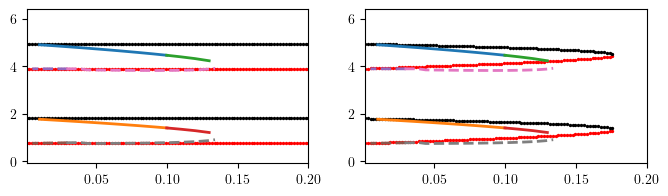

In [31]:
fig,axs = plt.subplots(1,2,figsize=(8,2))
kw_diagram = dict(a=a,b=b,eps_tup=etup,rhs=_redu_c2)
add_diagram_1d_scatter(axs[0],miter=1,**kw_diagram)
add_diagram_1d_scatter(axs[1],miter=2,**kw_diagram)

for i in range(2):
    draw_quick_plot_f(axs[i],data_bs_list,a)
    draw_quick_plot_f(axs[i],data_bu_list,a,ls='--')

#### Monodromys max

In [32]:
# get min eps
es_max,phi0 = get_es_max(data_bs_list,data_bu_list)


eigenvalues_temp = []
es_max_temp = []
for i in range(5):
    ee = es_max-0.0005*i
    m1 = get_monodromy_full(ee,phi0[-1],a,b,mname=mname_list[i].format(b))
    eigenvalues_temp.append(m1.eigenvalues)
    es_max_temp.append(ee)

b_max_all.append(b)
eigenvalues_max_all.append(eigenvalues_temp)
e_vals_mono_max.append(es_max_temp)

es_min,phi0 0.13400000000000004 0.9009439708309772
phi init 0.9009439708309772
Y [-0.11418489  0.21676966  0.08262602  0.40987997 -0.57873378  0.17348895  0.08124715  0.07738254  6.11492865]
mkdir ./data/thal2_32_b0=0.0025/
* Loading LC data...
self.T 6.114928675500715
loaded coupling expansions
* Loading monodromy...
* Floquet Exponent kappa = -0.002185577417374763
es_min,phi0 0.13350000000000004 0.9009439708309772
phi init 0.9009439708309772
Y [-1.23639197e-01  2.13696545e-01  8.06975544e-02  4.03824083e-01 -5.71882921e-01  5.54450286e-01  8.87752387e-02  1.16346785e-03  6.11541790e+00]
mkdir ./data/thal2_32_b1=0.0025/
* Loading LC data...
self.T 6.115417927448156
loaded coupling expansions
* Loading monodromy...
* Floquet Exponent kappa = -0.002341310640997199
es_min,phi0 0.13300000000000003 0.9009439708309772
phi init 0.9009439708309772
Y [-1.23318884e-01  2.27890034e-01  8.07743264e-02  3.85386266e-01 -5.73248994e-01  5.52694369e-01  8.88064100e-02  1.20325504e-03  6.11591086e+00]

In [33]:
b_vals_full.append(b)

es = get_smallest_eps(data_bs_list)
eu = get_smallest_eps(data_bu_list)

e_vals_full.append(0)

es = get_largest_eps(data_bs_list)
eu = get_largest_eps(data_bu_list)

e_hi_full.append(np.max([es,eu]))

### b=-0.0025

#### Branches eps stable

In [34]:
b=-.0025
kw_b['recompute'] = False
kw_b['b'] = b

In [35]:
# in_dicts = [dict(phi0=phi0,eps_init=0.1,eps_final=0,deps=-.01) for phi0 in np.linspace(0,2*np.pi,20)]
in_dicts = [dict(phi0=2,eps_init=0.1,eps_final=0,deps=-.01),
            dict(phi0=2,eps_init=0.099,eps_final=0.2,deps=.01)]

In [36]:
data_bs_list = []
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat = follow_phase_diffs(**in1,**kw_b)
    data_bs_list.append(dat)

phi init 2
phi init 2


In [37]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts),4])
for i in range(len(in_dicts)):
    hyp_inputs[i,0] = in_dicts[i]['phi0']
    hyp_inputs[i,1] = in_dicts[i]['eps_init']
    hyp_inputs[i,2] = in_dicts[i]['eps_final']
    hyp_inputs[i,3] = in_dicts[i]['deps']
np.savetxt(fname_bs.format(b),hyp_inputs)

#### Branches eps unstable

In [38]:
kw_b['recompute'] = False

In [39]:
kw_b['b'] = b

In [40]:
da,Yinit = follow_phase_diffs_u(**dict(phi0=3.5,eps_init=0.003,eps_final=0,deps=-2),return_point=True,**kw_b)
print(da)
# da,Yinit = follow_phase_diffs_u(**dict(phi0=4,eps_init=0.02,eps_final=0,deps=-2),use_point=Yinit,return_point=True,**kw_b)
# print(da)
# da,Yinit = follow_phase_diffs_u(**dict(phi0=4,eps_init=0.03,eps_final=0,deps=-2),use_point=Yinit,return_point=True,**kw_b)
# print(da)

phi init 3.5
phase_diffs_u_init=3.5_nm=32_b=-0.0025_ei=0.003_ef=0_de=-2.txt
phase_diffs_u_pt_init=3.5_nm=32_b=-0.0025_ei=0.003_ef=0_de=-2.txt
[3.00000000e-03 2.09287510e+00 2.09287510e+00 3.27398927e+00 1.34498153e-01]


In [41]:
in_dicts = [
    dict(phi0=3.9,eps_init=0.003,eps_final=0,deps=-.001),
    dict(phi0=3.9,eps_init=0.00299,eps_final=0.2,deps=.01),
]

In [42]:
data_bu_list = []
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat = follow_phase_diffs_u(use_point=Yinit,**in1,**kw_b)
    data_bu_list.append(dat)

phi init 3.9
phase_diffs_u_init=3.9_nm=32_b=-0.0025_ei=0.003_ef=0_de=-0.001.txt
phase_diffs_u_pt_init=3.9_nm=32_b=-0.0025_ei=0.003_ef=0_de=-0.001.txt
phi init 3.9
phase_diffs_u_init=3.9_nm=32_b=-0.0025_ei=0.00299_ef=0.2_de=0.01.txt
phase_diffs_u_pt_init=3.9_nm=32_b=-0.0025_ei=0.00299_ef=0.2_de=0.01.txt


In [43]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts),4])
for i in range(len(in_dicts)):
    hyp_inputs[i,0] = in_dicts[i]['phi0']
    hyp_inputs[i,1] = in_dicts[i]['eps_init']
    hyp_inputs[i,2] = in_dicts[i]['eps_final']
    hyp_inputs[i,3] = in_dicts[i]['deps']
np.savetxt(fname_bu.format(b),hyp_inputs)

#### Plot combined 1 par

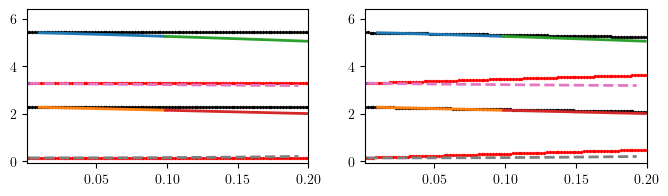

In [44]:
fig,axs = plt.subplots(1,2,figsize=(8,2))
kw_diagram = dict(a=a,b=b,eps_tup=etup,rhs=_redu_c2)
add_diagram_1d_scatter(axs[0],miter=1,**kw_diagram)
add_diagram_1d_scatter(axs[1],miter=2,**kw_diagram)

for i in range(2):
    draw_quick_plot_f(axs[i],data_bs_list,a)
    draw_quick_plot_f(axs[i],data_bu_list,a,ls='--')

In [45]:
b_vals_full.append(b)

es = get_smallest_eps(data_bs_list)
eu = get_smallest_eps(data_bu_list)

e_vals_full.append(0)

es = get_largest_eps(data_bs_list)
eu = get_largest_eps(data_bu_list)

e_hi_full.append(np.max([es,eu]))

### b=-0.005

#### Branches eps stable

In [46]:
b=-.005
kw_b['recompute'] = False
kw_b['b'] = b

In [47]:
# in_dicts = [dict(phi0=phi0,eps_init=0.1,eps_final=0,deps=-.01) for phi0 in np.linspace(0,2*np.pi,20)]
in_dicts = [dict(phi0=2,eps_init=0.1,eps_final=0,deps=-.01),
            dict(phi0=2,eps_init=0.099,eps_final=0.2,deps=.01)]

In [48]:
data_bs_list = []
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat = follow_phase_diffs(**in1,**kw_b)
    data_bs_list.append(dat)

phi init 2
phi init 2


In [49]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts),4])
for i in range(len(in_dicts)):
    hyp_inputs[i,0] = in_dicts[i]['phi0']
    hyp_inputs[i,1] = in_dicts[i]['eps_init']
    hyp_inputs[i,2] = in_dicts[i]['eps_final']
    hyp_inputs[i,3] = in_dicts[i]['deps']
np.savetxt(fname_bs.format(b),hyp_inputs)

#### Branches eps unstable

In [50]:
kw_b['recompute'] = False

In [51]:
# 5.66982483 2.52763065 # stable at eps=0.01
kw_b['b'] = 0
da,Yinit = follow_phase_diffs_u(**dict(phi0=3.5,eps_init=0.003,eps_final=0,deps=-2),tol=1e-6,return_point=True,**kw_b)
print(da)
da,Yinit = follow_phase_diffs_u(**dict(phi0=3.5,eps_init=0.01,eps_final=0,deps=-2),tol=1e-6,use_point=Yinit,return_point=True,**kw_b)
print(da)
da,Yinit = follow_phase_diffs_u(**dict(phi0=3.5,eps_init=0.03,eps_final=0,deps=-2),tol=1e-6,use_point=Yinit,return_point=True,**kw_b)
print(da)
da,Yinit = follow_phase_diffs_u(**dict(phi0=3.5,eps_init=0.05,eps_final=0,deps=-2),tol=1e-6,use_point=Yinit,return_point=True,**kw_b)
print(da,list(Yinit))
da,Yinit = follow_phase_diffs_u(**dict(phi0=3.5,eps_init=0.075,eps_final=0,deps=-2),tol=1e-6,use_point=Yinit,return_point=True,**kw_b)
print(da)
da,Yinit = follow_phase_diffs_u(**dict(phi0=3.5,eps_init=0.1,eps_final=0,deps=-2),tol=1e-6,use_point=Yinit,return_point=True,**kw_b)
print(da,list(Yinit))

phi init 3.5
phase_diffs_u_init=3.5_nm=32_b=0_ei=0.003_ef=0_de=-2.txt
phase_diffs_u_pt_init=3.5_nm=32_b=0_ei=0.003_ef=0_de=-2.txt
[3.00000000e-03 2.09270618e+00 2.09270618e+00 3.57094699e+00 4.26351854e-01]
phi init 3.5
phase_diffs_u_init=3.5_nm=32_b=0_ei=0.01_ef=0_de=-2.txt
phase_diffs_u_pt_init=3.5_nm=32_b=0_ei=0.01_ef=0_de=-2.txt
[0.01       2.08937279 2.08937279 3.55659564 0.42101752]
phi init 3.5
phase_diffs_u_init=3.5_nm=32_b=0_ei=0.03_ef=0_de=-2.txt
phase_diffs_u_pt_init=3.5_nm=32_b=0_ei=0.03_ef=0_de=-2.txt
[0.03       2.08003928 2.08003928 3.51012564 0.39269908]
phi init 3.5
phase_diffs_u_init=3.5_nm=32_b=0_ei=0.05_ef=0_de=-2.txt
phase_diffs_u_pt_init=3.5_nm=32_b=0_ei=0.05_ef=0_de=-2.txt
[0.05       2.07070577 2.07070577 3.46930547 0.37019411] [-0.5731653663110687, 0.5534051706502733, 0.09610160013365669, 0.0011995560895133406, -0.1096986882133124, 0.22606647172748065, 0.09001673183008534, 0.4036401816222591, 6.212039378814412]
phi init 3.5
phase_diffs_u_init=3.5_nm=32_b=0_ei=0

In [65]:
# 5.66982483 2.52763065 # stable at eps=0.01
kw_b['b'] = -0.0025
da,Yinit = follow_phase_diffs_u(**dict(phi0=3.5,eps_init=0.003,eps_final=0,deps=-2),return_point=True,**kw_b)
print(da,list(Yinit))
kw_b['b'] = -0.0035
da,Yinit = follow_phase_diffs_u(**dict(phi0=3.5,eps_init=0.005,eps_final=0,deps=-2),use_point=Yinit,return_point=True,**kw_b)
print(da,list(Yinit))
kw_b['b'] = -0.0045
da,Yinit = follow_phase_diffs_u(**dict(phi0=3.5,eps_init=0.008,eps_final=0,deps=-2),use_point=Yinit,return_point=True,**kw_b)
print(da)
kw_b['b'] = -0.005
da,Yinit = follow_phase_diffs_u(**dict(phi0=3.5,eps_init=0.01,eps_final=0,deps=-2),use_point=Yinit,return_point=True,**kw_b)
print(da,list(Yinit))

phi init 3.5
phase_diffs_u_init=3.5_nm=32_b=-0.0025_ei=0.003_ef=0_de=-2.txt
phase_diffs_u_pt_init=3.5_nm=32_b=-0.0025_ei=0.003_ef=0_de=-2.txt
[3.00000000e-03 2.09287510e+00 2.09287510e+00 3.27398927e+00 1.34498153e-01] [-0.5812786304778219, 0.5433677776371054, 0.0994221337916043, 0.001465831229004558, -0.10757208408107807, 0.22603152239015184, 0.09361838543965177, 0.4059634384180048, 6.278563406427839]
phi init 3.5
phase_diffs_u_init=3.5_nm=32_b=-0.0035_ei=0.005_ef=0_de=-2.txt
phase_diffs_u_pt_init=3.5_nm=32_b=-0.0035_ei=0.005_ef=0_de=-2.txt
[0.005      2.09174176 2.09174176 3.14399571 0.00480611] [-0.5885665741006565, 0.5281379516882104, 0.09912819298330922, 0.0018987803887340637, -0.10767322448879131, 0.22438126348515572, 0.09348376685586182, 0.40780078310724055, 6.2753649553681825]
phi init 3.5
phase_diffs_u_init=3.5_nm=32_b=-0.0045_ei=0.008_ef=0_de=-2.txt
phase_diffs_u_pt_init=3.5_nm=32_b=-0.0045_ei=0.008_ef=0_de=-2.txt
[0.008      2.09020842 2.09020842 6.15212279 3.00722351]
phi i

In [52]:
kw_b['b'] = b

In [53]:
in_dicts = [
    dict(phi0=3.5,eps_init=0.01,eps_final=0,deps=-.002),
    dict(phi0=3.5,eps_init=0.0099,eps_final=0.2,deps=.002,max_iter=50),
]

In [54]:
data_bu_list = []
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat = follow_phase_diffs_u(use_point=Yinit,**in1,**kw_b)
    data_bu_list.append(dat)

phi init 3.5
phase_diffs_u_init=3.5_nm=32_b=-0.005_ei=0.01_ef=0_de=-0.002.txt
phase_diffs_u_pt_init=3.5_nm=32_b=-0.005_ei=0.01_ef=0_de=-0.002.txt
phi init 3.5
phase_diffs_u_init=3.5_nm=32_b=-0.005_ei=0.0099_ef=0.2_de=0.002.txt
phase_diffs_u_pt_init=3.5_nm=32_b=-0.005_ei=0.0099_ef=0.2_de=0.002.txt


In [55]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts),4])
for i in range(len(in_dicts)):
    hyp_inputs[i,0] = in_dicts[i]['phi0']
    hyp_inputs[i,1] = in_dicts[i]['eps_init']
    hyp_inputs[i,2] = in_dicts[i]['eps_final']
    hyp_inputs[i,3] = in_dicts[i]['deps']
np.savetxt(fname_bu.format(b),hyp_inputs)

#### Plot combined 1 par

KeyboardInterrupt: 

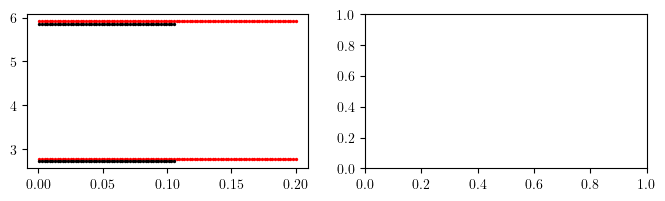

In [56]:
fig,axs = plt.subplots(1,2,figsize=(8,2))
kw_diagram = dict(a=a,b=b,eps_tup=etup,rhs=_redu_c2)
add_diagram_1d_scatter(axs[0],miter=1,**kw_diagram)
add_diagram_1d_scatter(axs[1],miter=2,**kw_diagram)

for i in range(2):
    draw_quick_plot_f(axs[i],data_bs_list,a)
    draw_quick_plot_f(axs[i],data_bu_list,a,ls='--')

#### Monodromys max

In [ ]:
# # get min eps
# es_max,phi0 = get_es_max(data_bs_list,data_bu_list)


# eigenvalues_temp = []
# es_max_temp = []
# for i in range(5):
#     ee = es_max-0.0005*i
#     m1 = get_monodromy_full(ee,phi0[-1],a,b,mname=mname_list[i].format(b))
#     eigenvalues_temp.append(m1.eigenvalues)
#     es_max_temp.append(ee)

# b_max_all.append(b)
# eigenvalues_max_all.append(eigenvalues_temp)
# e_vals_mono_max.append(es_max_temp)

In [ ]:
b_vals_full.append(b)

es = get_smallest_eps(data_bs_list)
eu = get_smallest_eps(data_bu_list)

e_vals_full.append(0)

es = get_largest_eps(data_bs_list)
eu = get_largest_eps(data_bu_list)

e_hi_full.append(np.max([es,eu]))

### b=-0.007

#### Branches eps stable

In [ ]:
b=-.007
kw_b['recompute'] = False
kw_b['b'] = b

In [ ]:
# in_dicts = [dict(phi0=phi0,eps_init=0.1,eps_final=0,deps=-.01) for phi0 in np.linspace(0,2*np.pi,20)]
in_dicts = [dict(phi0=2,eps_init=0.1,eps_final=0,deps=-.01),
            dict(phi0=2,eps_init=0.099,eps_final=0.2,deps=.002)]

In [ ]:
data_bs_list = []
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat = follow_phase_diffs(**in1,**kw_b)
    data_bs_list.append(dat)

In [ ]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts),4])
for i in range(len(in_dicts)):
    hyp_inputs[i,0] = in_dicts[i]['phi0']
    hyp_inputs[i,1] = in_dicts[i]['eps_init']
    hyp_inputs[i,2] = in_dicts[i]['eps_final']
    hyp_inputs[i,3] = in_dicts[i]['deps']
np.savetxt(fname_bs.format(b),hyp_inputs)

#### Branches eps unstable

In [ ]:
kw_b['recompute'] = False

In [64]:
kw_b['b'] = -0.005
da,Yinit = follow_phase_diffs_u(**dict(phi0=3.5,eps_init=0.01,eps_final=0,deps=-2),return_point=True,**kw_b)
print(da)
print(Yinit)
kw_b['b'] = -0.0055
da,Yinit = follow_phase_diffs_u(**dict(phi0=3.5,eps_init=0.02,eps_final=0,deps=-2),use_point=Yinit,max_iter=30,return_point=True,**kw_b)
print(da)
kw_b['b'] = -0.0055
da,Yinit = follow_phase_diffs_u(**dict(phi0=3.5,eps_init=0.03,eps_final=0,deps=-2),use_point=Yinit,max_iter=30,return_point=True,**kw_b)
print(da)
kw_b['b'] = -0.0055
da,Yinit = follow_phase_diffs_u(**dict(phi0=3.5,eps_init=0.03999,eps_final=0,deps=-2),use_point=Yinit,max_iter=30,return_point=True,**kw_b)
print(da)
kw_b['b'] = -0.0056
da,Yinit = follow_phase_diffs_u(**dict(phi0=3.5,eps_init=0.05,eps_final=0,deps=-2),use_point=Yinit,max_iter=30,return_point=True,**kw_b)
print(da)
kw_b['b'] = -0.0057
da,Yinit = follow_phase_diffs_u(**dict(phi0=3.5,eps_init=0.06,eps_final=0,deps=-2),use_point=Yinit,max_iter=30,return_point=True,**kw_b)
print(da)
# [0.04       2.07400835 2.07400835 5.47188491 2.33635126]

phi init 3.5
phase_diffs_u_init=3.5_nm=32_b=-0.005_ei=0.01_ef=0_de=-2.txt
phase_diffs_u_pt_init=3.5_nm=32_b=-0.005_ei=0.01_ef=0_de=-2.txt
[0.01       2.08907508 2.08907508 6.07806345 2.93286161]
phi init 3.5
phase_diffs_u_init=3.5_nm=32_b=-0.0055_ei=0.02_ef=0_de=-2.txt
phase_diffs_u_pt_init=3.5_nm=32_b=-0.0055_ei=0.02_ef=0_de=-2.txt
[0.02       2.08394173 2.08394173 6.10167866 2.95254835]
phi init 3.5
phase_diffs_u_init=3.5_nm=32_b=-0.0055_ei=0.03_ef=0_de=-2.txt
phase_diffs_u_pt_init=3.5_nm=32_b=-0.0055_ei=0.03_ef=0_de=-2.txt
[0.03       2.07894171 2.07894171 6.19432933 3.03883404]
phi init 3.5
phase_diffs_u_init=3.5_nm=32_b=-0.0055_ei=0.03999_ef=0_de=-2.txt
phase_diffs_u_pt_init=3.5_nm=32_b=-0.0055_ei=0.03999_ef=0_de=-2.txt
[0.03999    2.07414169 2.07414169 6.27106808 3.10766442]
phi init 3.5
phase_diffs_u_init=3.5_nm=32_b=-0.0056_ei=0.05_ef=0_de=-2.txt
phase_diffs_u_pt_init=3.5_nm=32_b=-0.0056_ei=0.05_ef=0_de=-2.txt
[0.05       2.069475   2.069475   3.16952512 0.05829384]
phi init 3.

In [65]:
kw_b['b'] = -0.0058
da,Yinit = follow_phase_diffs_u(**dict(phi0=3.5,eps_init=0.07,eps_final=0,deps=-2),use_point=Yinit,max_iter=30,return_point=True,**kw_b)
print(da)
kw_b['b'] = -0.0059
da,Yinit = follow_phase_diffs_u(**dict(phi0=3.5,eps_init=0.08,eps_final=0,deps=-2),use_point=Yinit,max_iter=30,return_point=True,**kw_b)
print(da)
kw_b['b'] = -0.006
da,Yinit = follow_phase_diffs_u(**dict(phi0=3.5,eps_init=0.09,eps_final=0,deps=-2),use_point=Yinit,max_iter=30,return_point=True,**kw_b)
print(da)
kw_b['b'] = -0.0061
da,Yinit = follow_phase_diffs_u(**dict(phi0=3.5,eps_init=0.1,eps_final=0,deps=-2),use_point=Yinit,max_iter=30,return_point=True,**kw_b)
print(da)
kw_b['b'] = -0.0062
da,Yinit = follow_phase_diffs_u(**dict(phi0=3.5,eps_init=0.11,eps_final=0,deps=-2),use_point=Yinit,max_iter=30,return_point=True,**kw_b)
print(da)

phi init 3.5
phase_diffs_u_init=3.5_nm=32_b=-0.0058_ei=0.07_ef=0_de=-2.txt
phase_diffs_u_pt_init=3.5_nm=32_b=-0.0058_ei=0.07_ef=0_de=-2.txt
[0.07       2.06087497 2.06087497 3.29860623 0.20853842]
phi init 3.5
phase_diffs_u_init=3.5_nm=32_b=-0.0059_ei=0.08_ef=0_de=-2.txt
phase_diffs_u_pt_init=3.5_nm=32_b=-0.0059_ei=0.08_ef=0_de=-2.txt
[0.08       2.05687495 2.05687495 3.36794861 0.29019995]
phi init 3.5
phase_diffs_u_init=3.5_nm=32_b=-0.006_ei=0.09_ef=0_de=-2.txt
phase_diffs_u_pt_init=3.5_nm=32_b=-0.006_ei=0.09_ef=0_de=-2.txt
[0.09       2.0531416  2.0531416  3.44303131 0.37825196]
phi init 3.5
phase_diffs_u_init=3.5_nm=32_b=-0.0061_ei=0.1_ef=0_de=-2.txt
phase_diffs_u_pt_init=3.5_nm=32_b=-0.0061_ei=0.1_ef=0_de=-2.txt
[0.1        2.04967492 2.04967492 3.52630875 0.47576046]
phi init 3.5
phase_diffs_u_init=3.5_nm=32_b=-0.0062_ei=0.11_ef=0_de=-2.txt
phase_diffs_u_pt_init=3.5_nm=32_b=-0.0062_ei=0.11_ef=0_de=-2.txt
[0.11       2.04647491 2.04647491 3.62454459 0.58887592]


In [66]:
kw_b['b'] = -0.0063
da,Yinit = follow_phase_diffs_u(**dict(phi0=3.5,eps_init=0.12,eps_final=0,deps=-2),use_point=Yinit,max_iter=30,return_point=True,**kw_b)
print(da)
kw_b['b'] = -0.0063
da,Yinit = follow_phase_diffs_u(**dict(phi0=3.5,eps_init=0.13,eps_final=0,deps=-2),use_point=Yinit,max_iter=30,return_point=True,**kw_b)
print(da)
kw_b['b'] = -0.0063
da,Yinit = follow_phase_diffs_u(**dict(phi0=3.5,eps_init=0.1,eps_final=0,deps=-2),use_point=Yinit,max_iter=30,return_point=True,**kw_b)
print(da)
kw_b['b'] = -0.0065
da,Yinit = follow_phase_diffs_u(**dict(phi0=3.5,eps_init=0.1,eps_final=0,deps=-2),use_point=Yinit,max_iter=30,return_point=True,**kw_b)
print(da)
kw_b['b'] = -0.007
da,Yinit = follow_phase_diffs_u(**dict(phi0=3.5,eps_init=0.1,eps_final=0,deps=-2),use_point=Yinit,max_iter=30,return_point=True,**kw_b)
print(da)

phi init 3.5
phase_diffs_u_init=3.5_nm=32_b=-0.0063_ei=0.12_ef=0_de=-2.txt
phase_diffs_u_pt_init=3.5_nm=32_b=-0.0063_ei=0.12_ef=0_de=-2.txt
[0.12       2.0434749  2.0434749  3.75531629 0.73548443]
phi init 3.5
phase_diffs_u_init=3.5_nm=32_b=-0.0063_ei=0.13_ef=0_de=-2.txt
phase_diffs_u_pt_init=3.5_nm=32_b=-0.0063_ei=0.13_ef=0_de=-2.txt
[0.13       2.04027488 2.04027488 3.93612693 0.92757258]
phi init 3.5
phase_diffs_u_init=3.5_nm=32_b=-0.0063_ei=0.1_ef=0_de=-2.txt
phase_diffs_u_pt_init=3.5_nm=32_b=-0.0063_ei=0.1_ef=0_de=-2.txt
[0.1        2.05000826 2.05000826 3.56333231 0.5149147 ]
phi init 3.5
phase_diffs_u_init=3.5_nm=32_b=-0.0065_ei=0.1_ef=0_de=-2.txt
phase_diffs_u_pt_init=3.5_nm=32_b=-0.0065_ei=0.1_ef=0_de=-2.txt
[0.1        2.05027492 2.05027492 3.60372978 0.55713879]
phi init 3.5
phase_diffs_u_init=3.5_nm=32_b=-0.007_ei=0.1_ef=0_de=-2.txt
phase_diffs_u_pt_init=3.5_nm=32_b=-0.007_ei=0.1_ef=0_de=-2.txt
[0.1        2.05107493 2.05107493 3.72547183 0.68313251]


In [67]:
kw_b['b'] = b

In [68]:
in_dicts = [
    dict(phi0=3.5,eps_init=0.1,eps_final=0,deps=-.002),
    dict(phi0=3.5,eps_init=0.099,eps_final=0.2,deps=.002,max_iter=50),
]

In [69]:
data_bu_list = []
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat = follow_phase_diffs_u(use_point=Yinit,**in1,**kw_b)
    data_bu_list.append(dat)

phi init 3.5
phase_diffs_u_init=3.5_nm=32_b=-0.007_ei=0.1_ef=0_de=-0.002.txt
phase_diffs_u_pt_init=3.5_nm=32_b=-0.007_ei=0.1_ef=0_de=-0.002.txt
phi init 3.5
phase_diffs_u_init=3.5_nm=32_b=-0.007_ei=0.099_ef=0.2_de=0.002.txt
phase_diffs_u_pt_init=3.5_nm=32_b=-0.007_ei=0.099_ef=0.2_de=0.002.txt


In [70]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts),4])
for i in range(len(in_dicts)):
    hyp_inputs[i,0] = in_dicts[i]['phi0']
    hyp_inputs[i,1] = in_dicts[i]['eps_init']
    hyp_inputs[i,2] = in_dicts[i]['eps_final']
    hyp_inputs[i,3] = in_dicts[i]['deps']
np.savetxt(fname_bu.format(b),hyp_inputs)

#### Plot combined 1 par

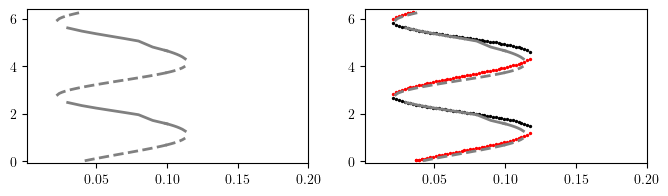

In [71]:
fig,axs = plt.subplots(1,2,figsize=(8,2))
kw_diagram = dict(a=a,b=b,eps_tup=etup,rhs=_redu_c2)
add_diagram_1d_scatter(axs[0],miter=1,**kw_diagram)
add_diagram_1d_scatter(axs[1],miter=2,**kw_diagram)

for i in range(2):
    draw_quick_plot_f(axs[i],data_bs_list,a)
    draw_quick_plot_f(axs[i],data_bu_list,a,ls='--')

#### Monodromys min

In [72]:
# get min eps
es_min,phi0 = get_es_min(data_bs_list,data_bu_list)


eigenvalues_temp = []
es_min_temp = []
for i in range(5):
    ee = es_min+0.0005*i
    m1 = get_monodromy_full(ee,phi0[-1],a,b,mname=mname_list[i].format(b))
    eigenvalues_temp.append(m1.eigenvalues)
    es_min_temp.append(ee)

b_min_all.append(b)
eigenvalues_min_all.append(eigenvalues_temp)
e_vals_mono_min.append(es_min_temp)
#m1b = get_monodromy_full(es_min+.005,phi0[-1],a,b,mname=mname2.format(b))
# m1c = get_monodromy_full(es_min+.02,phi0[-1],a,b,mname=mname3.format(b))
#

#print(m1.eigenvalues)
#print(m1b.eigenvalues)

es_min,phi0 0.021999999999999936 5.895853267950729
phi init 5.895853267950729
Y [-0.10718919  0.22302349  0.09236324  0.40948086 -0.21433625  0.08659024  0.09137704  0.51929656  6.24849601]
mkdir ./data/thal2_32_b0=-0.007/
* Loading LC data...
self.T 6.2484960183054215
loaded coupling expansions
* Loading monodromy...
* Floquet Exponent kappa = -0.00027695007375471526
es_min,phi0 0.022499999999999937 5.895853267950729
phi init 5.895853267950729
Y [-0.10739281  0.21718807  0.0922796   0.41622009 -0.2316294   0.08160577  0.09125405  0.49095594  6.24773281]
mkdir ./data/thal2_32_b1=-0.007/
* Loading LC data...
self.T 6.247732820963388
loaded coupling expansions
* Loading monodromy...
* Floquet Exponent kappa = -0.0006525160090305425
es_min,phi0 0.022999999999999937 5.895853267950729
phi init 5.895853267950729
Y [-1.08070684e-01  2.20255129e-01  9.22971085e-02  4.12268261e-01 -4.99880967e-01  6.39327688e-01  9.70590779e-02  1.19912816e-04  6.24697262e+00]
mkdir ./data/thal2_32_b2=-0.007/
*

#### Monodromys max

In [73]:
# get min eps
es_max,phi0 = get_es_max(data_bs_list,data_bu_list)


eigenvalues_temp = []
es_max_temp = []
for i in range(5):
    ee = es_max-0.0005*i
    m1 = get_monodromy_full(ee,phi0[-1],a,b,mname=mname_list[i].format(b))
    eigenvalues_temp.append(m1.eigenvalues)
    es_max_temp.append(ee)

b_max_all.append(b)
eigenvalues_max_all.append(eigenvalues_temp)
e_vals_mono_max.append(es_max_temp)
#m1b = get_monodromy_full(es_max+.005,phi0[-1],a,b,mname=mname2.format(b))
# m1c = get_monodromy_full(es_max+.02,phi0[-1],a,b,mname=mname3.format(b))
#

#print(m1.eigenvalues)
#print(m1b.eigenvalues)

es_min,phi0 0.11300000000000002 1.2640073667816125
phi init 1.2640073667816125
Y [-0.11186971  0.2252162   0.08395789  0.40196961 -0.56774751  0.15916247  0.08256368  0.08925955  6.13791368]
mkdir ./data/thal2_32_b0=-0.007/
* Loading LC data...
self.T 6.2484960183054215
loaded coupling expansions
* Loading monodromy...
* Floquet Exponent kappa = -0.00027695007375471526
es_min,phi0 0.11250000000000002 1.2640073667816125
phi init 1.2640073667816125
Y [-0.11166223  0.23021926  0.0839838   0.39617726 -0.56434969  0.15546594  0.0826151   0.09269864  6.1381747 ]
mkdir ./data/thal2_32_b1=-0.007/
* Loading LC data...
self.T 6.247732820963388
loaded coupling expansions
* Loading monodromy...
* Floquet Exponent kappa = -0.0006525160090305425
es_min,phi0 0.11200000000000002 1.2640073667816125
phi init 1.2640073667816125
Y [-0.11173041  0.23840394  0.08402687  0.38645081 -0.56072345  0.15170007  0.08266822  0.0964024   6.13846229]
mkdir ./data/thal2_32_b2=-0.007/
* Loading LC data...
self.T 6.2469

In [74]:
b_vals_full.append(b)

es = get_smallest_eps(data_bs_list)
eu = get_smallest_eps(data_bu_list)

e_vals_full.append(np.min([es,eu]))

es = get_largest_eps(data_bs_list)
eu = get_largest_eps(data_bu_list)

e_hi_full.append(np.max([es,eu]))

### b=-0.01

#### Branches eps stable

In [75]:
b=-.01
kw_b['recompute'] = False
kw_b['b'] = b

In [76]:
# in_dicts = [dict(phi0=phi0,eps_init=0.1,eps_final=0,deps=-.01) for phi0 in np.linspace(0,2*np.pi,20)]
in_dicts = [dict(phi0=2,eps_init=0.05,eps_final=0,deps=-.01),
            dict(phi0=2,eps_init=0.0499,eps_final=0.2,deps=.01)]

In [77]:
data_bs_list = []
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat = follow_phase_diffs(**in1,**kw_b)
    data_bs_list.append(dat)

phi init 2
phi init 2


In [78]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts),4])
for i in range(len(in_dicts)):
    hyp_inputs[i,0] = in_dicts[i]['phi0']
    hyp_inputs[i,1] = in_dicts[i]['eps_init']
    hyp_inputs[i,2] = in_dicts[i]['eps_final']
    hyp_inputs[i,3] = in_dicts[i]['deps']
np.savetxt(fname_bs.format(b),hyp_inputs)

#### Branches eps unstable

In [79]:
kw_b['recompute'] = False

In [80]:
# 5.66982483 2.52763065 # stable at eps=0.01
kw_b['b'] = -0.005
da,Yinit = follow_phase_diffs_u(**dict(phi0=3.5,eps_init=0.01,eps_final=0,deps=-2),use_point=Yinit,return_point=True,**kw_b)
print(da)
kw_b['b'] = -0.0055
da,Yinit = follow_phase_diffs_u(**dict(phi0=3.5,eps_init=0.011,eps_final=0,deps=-2),use_point=Yinit,return_point=True,**kw_b)
print(da)
kw_b['b'] = -0.0055
da,Yinit = follow_phase_diffs_u(**dict(phi0=3.5,eps_init=0.012,eps_final=0,deps=-2),use_point=Yinit,return_point=True,**kw_b)
print(da)
kw_b['b'] = -0.00569
da,Yinit = follow_phase_diffs_u(**dict(phi0=3.5,eps_init=0.012,eps_final=0,deps=-2),tol=1e-6,use_point=Yinit,return_point=True,**kw_b)
print(da)
kw_b['b'] = -0.00569
da,Yinit = follow_phase_diffs_u(**dict(phi0=3.5,eps_init=0.013,eps_final=0,deps=-2),tol=1e-6,use_point=Yinit,return_point=True,**kw_b)
print(da)
kw_b['b'] = -0.00569
da,Yinit = follow_phase_diffs_u(**dict(phi0=3.5,eps_init=0.015,eps_final=0,deps=-2),tol=1e-6,use_point=Yinit,return_point=True,**kw_b)
print(da)
kw_b['b'] = -0.00569
da,Yinit = follow_phase_diffs_u(**dict(phi0=3.5,eps_init=0.02,eps_final=0,deps=-2),tol=1e-6,use_point=Yinit,return_point=True,**kw_b)
print(da)
kw_b['b'] = -0.00569
da,Yinit = follow_phase_diffs_u(**dict(phi0=3.5,eps_init=0.03,eps_final=0,deps=-2),tol=1e-6,use_point=Yinit,return_point=True,**kw_b)
print(da)
kw_b['b'] = -0.006
da,Yinit = follow_phase_diffs_u(**dict(phi0=3.5,eps_init=0.03,eps_final=0,deps=-2),tol=1e-6,use_point=Yinit,return_point=True,**kw_b)
print(da)
kw_b['b'] = -0.007
da,Yinit = follow_phase_diffs_u(**dict(phi0=3.5,eps_init=0.03,eps_final=0,deps=-2),tol=1e-6,use_point=Yinit,return_point=True,**kw_b)
print(da)
kw_b['b'] = -0.008
da,Yinit = follow_phase_diffs_u(**dict(phi0=3.5,eps_init=0.03,eps_final=0,deps=-2),tol=1e-6,use_point=Yinit,return_point=True,**kw_b)
print(da)
kw_b['b'] = -0.009
da,Yinit = follow_phase_diffs_u(**dict(phi0=3.5,eps_init=0.03,eps_final=0,deps=-2),tol=1e-6,use_point=Yinit,return_point=True,**kw_b)
print(da)
kw_b['b'] = -0.0095
da,Yinit = follow_phase_diffs_u(**dict(phi0=3.5,eps_init=0.03,eps_final=0,deps=-2),tol=1e-6,use_point=Yinit,return_point=True,**kw_b)
print(da)

phi init 3.5
phase_diffs_u_init=3.5_nm=32_b=-0.005_ei=0.01_ef=0_de=-2.txt
phase_diffs_u_pt_init=3.5_nm=32_b=-0.005_ei=0.01_ef=0_de=-2.txt
[0.01       2.08907508 2.08907508 6.07806345 2.93286161]
phi init 3.5
phase_diffs_u_init=3.5_nm=32_b=-0.0055_ei=0.011_ef=0_de=-2.txt
phase_diffs_u_pt_init=3.5_nm=32_b=-0.0055_ei=0.011_ef=0_de=-2.txt
[0.011      2.08854175 2.08854175 5.96730121 2.82270014]
phi init 3.5
phase_diffs_u_init=3.5_nm=32_b=-0.0055_ei=0.012_ef=0_de=-2.txt
phase_diffs_u_pt_init=3.5_nm=32_b=-0.0055_ei=0.012_ef=0_de=-2.txt
[0.012      2.08800841 2.08800841 5.99009036 2.84488668]
phi init 3.5
phase_diffs_u_init=3.5_nm=32_b=-0.00569_ei=0.012_ef=0_de=-2.txt
phase_diffs_u_pt_init=3.5_nm=32_b=-0.00569_ei=0.012_ef=0_de=-2.txt
[0.012      2.08800841 2.08800841 5.9028239  2.75882389]
phi init 3.5
phase_diffs_u_init=3.5_nm=32_b=-0.00569_ei=0.013_ef=0_de=-2.txt
phase_diffs_u_pt_init=3.5_nm=32_b=-0.00569_ei=0.013_ef=0_de=-2.txt
[0.013      2.08747507 2.08747507 5.95088603 2.80568143]
phi i

In [81]:
kw_b['b'] = b

In [82]:
in_dicts = [
    dict(phi0=3.5,eps_init=0.03,eps_final=0,deps=-.002),
    dict(phi0=3.5,eps_init=0.0299,eps_final=0.2,deps=.002,max_iter=50),
]

In [83]:
data_bu_list = []
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat = follow_phase_diffs_u(use_point=Yinit,**in1,**kw_b)
    data_bu_list.append(dat)

phi init 3.5
phase_diffs_u_init=3.5_nm=32_b=-0.01_ei=0.03_ef=0_de=-0.002.txt
phase_diffs_u_pt_init=3.5_nm=32_b=-0.01_ei=0.03_ef=0_de=-0.002.txt
phi init 3.5
phase_diffs_u_init=3.5_nm=32_b=-0.01_ei=0.0299_ef=0.2_de=0.002.txt
phase_diffs_u_pt_init=3.5_nm=32_b=-0.01_ei=0.0299_ef=0.2_de=0.002.txt


In [84]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts),4])
for i in range(len(in_dicts)):
    hyp_inputs[i,0] = in_dicts[i]['phi0']
    hyp_inputs[i,1] = in_dicts[i]['eps_init']
    hyp_inputs[i,2] = in_dicts[i]['eps_final']
    hyp_inputs[i,3] = in_dicts[i]['deps']
np.savetxt(fname_bu.format(b),hyp_inputs)

#### Plot combined 1 par

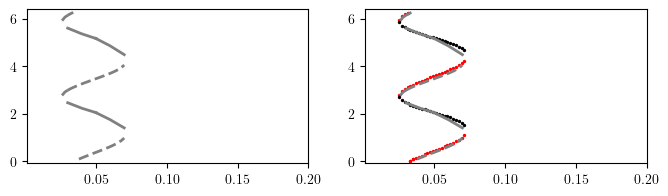

In [85]:
fig,axs = plt.subplots(1,2,figsize=(8,2))
kw_diagram = dict(a=a,b=b,eps_tup=etup,rhs=_redu_c2)
add_diagram_1d_scatter(axs[0],miter=1,**kw_diagram)
add_diagram_1d_scatter(axs[1],miter=2,**kw_diagram)

for i in range(2):
    draw_quick_plot_f(axs[i],data_bs_list,a)
    draw_quick_plot_f(axs[i],data_bu_list,a,ls='--')

#### Monodromys min

In [86]:
# get min eps
es_min,phi0 = get_es_min(data_bs_list,data_bu_list)


eigenvalues_temp = []
es_min_temp = []
for i in range(5):
    ee = es_min+0.0005*i
    m1 = get_monodromy_full(ee,phi0[-1],a,b,mname=mname_list[i].format(b))
    eigenvalues_temp.append(m1.eigenvalues)
    es_min_temp.append(ee)

b_min_all.append(b)
eigenvalues_min_all.append(eigenvalues_temp)
e_vals_mono_min.append(es_min_temp)
#m1b = get_monodromy_full(es_min+.005,phi0[-1],a,b,mname=mname2.format(b))
# m1c = get_monodromy_full(es_min+.02,phi0[-1],a,b,mname=mname3.format(b))
#

#print(m1.eigenvalues)
#print(m1b.eigenvalues)

es_min,phi0 0.025999999999999995 2.7647464759965548
phi init 2.7647464759965548
Y [-1.08212010e-01  2.37895225e-01  9.21828322e-02  3.91494905e-01 -5.02806559e-01  6.37276252e-01  9.69378720e-02  1.30139470e-04  6.24233953e+00]
mkdir ./data/thal2_32_b0=-0.01/
* Loading LC data...
self.T 6.242339544688166
loaded coupling expansions
* Loading monodromy...
* Floquet Exponent kappa = -0.0005364401208144708
es_min,phi0 0.026499999999999996 2.7647464759965548
phi init 2.7647464759965548
Y [-0.10731872  0.23984785  0.09206425  0.38981237 -0.23547805  0.08080915  0.09097499  0.48423947  6.24160078]
mkdir ./data/thal2_32_b1=-0.01/
* Loading LC data...
self.T 6.241600787048197
loaded coupling expansions
* Loading monodromy...
* Floquet Exponent kappa = -0.0011470103972748263
es_min,phi0 0.026999999999999996 2.7647464759965548
phi init 2.7647464759965548
Y [-1.08087637e-01  2.35824417e-01  9.20712678e-02  3.94001966e-01 -4.98573630e-01  6.39945094e-01  9.67382243e-02  1.15446150e-04  6.24086584e+

#### Monodromys max

In [87]:
# get min eps
es_max,phi0 = get_es_max(data_bs_list,data_bu_list)


eigenvalues_temp = []
es_max_temp = []
for i in range(5):
    ee = es_max-0.0005*i
    m1 = get_monodromy_full(ee,phi0[-1],a,b,mname=mname_list[i].format(b))
    eigenvalues_temp.append(m1.eigenvalues)
    es_max_temp.append(ee)

b_max_all.append(b)
eigenvalues_max_all.append(eigenvalues_temp)
e_vals_mono_max.append(es_max_temp)
#m1b = get_monodromy_full(es_max+.005,phi0[-1],a,b,mname=mname2.format(b))
# m1c = get_monodromy_full(es_max+.02,phi0[-1],a,b,mname=mname3.format(b))
#

#print(m1.eigenvalues)
#print(m1b.eigenvalues)

es_min,phi0 0.0699 1.397910257866318
phi init 1.397910257866318
Y [-1.17401434e-01  2.28773404e-01  8.61645186e-02  3.91594775e-01 -5.83594494e-01  5.35611972e-01  9.35644616e-02  1.65565369e-03  6.18918585e+00]
mkdir ./data/thal2_32_b0=-0.01/
* Loading LC data...
self.T 6.242339544688166
loaded coupling expansions
* Loading monodromy...
* Floquet Exponent kappa = -0.0005364401208144708
es_min,phi0 0.0694 1.397910257866318
phi init 1.397910257866318
Y [-1.17491605e-01  2.23052279e-01  8.62041446e-02  3.98654628e-01 -5.84541405e-01  5.33524800e-01  9.36332618e-02  1.71564280e-03  6.18947325e+00]
mkdir ./data/thal2_32_b1=-0.01/
* Loading LC data...
self.T 6.241600787048197
loaded coupling expansions
* Loading monodromy...
* Floquet Exponent kappa = -0.0011470103972748263
es_min,phi0 0.0689 1.397910257866318
phi init 1.397910257866318
Y [-1.07514833e-01  2.29816634e-01  8.81648301e-02  4.01678059e-01 -4.39365532e-01  6.52683405e-01  9.04745722e-02  2.75779062e-05  6.18979550e+00]
mkdir ./

In [88]:
b_vals_full.append(b)

es = get_smallest_eps(data_bs_list)
eu = get_smallest_eps(data_bu_list)

e_vals_full.append(np.min([es,eu]))

es = get_largest_eps(data_bs_list)
eu = get_largest_eps(data_bu_list)

e_hi_full.append(np.max([es,eu]))

### b=-0.02

#### Branches eps stable

In [89]:
b=-.02
kw_b['recompute'] = False
kw_b['b'] = b

In [90]:
# in_dicts = [dict(phi0=phi0,eps_init=0.1,eps_final=0,deps=-.01) for phi0 in np.linspace(0,2*np.pi,20)]
in_dicts = [dict(phi0=2,eps_init=0.025,eps_final=0,deps=-.001),
            dict(phi0=2,eps_init=0.02499,eps_final=0.2,deps=.001)]

In [91]:
data_bs_list = []
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat = follow_phase_diffs(**in1,**kw_b)
    data_bs_list.append(dat)

phi init 2
phi init 2


In [92]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts),4])
for i in range(len(in_dicts)):
    hyp_inputs[i,0] = in_dicts[i]['phi0']
    hyp_inputs[i,1] = in_dicts[i]['eps_init']
    hyp_inputs[i,2] = in_dicts[i]['eps_final']
    hyp_inputs[i,3] = in_dicts[i]['deps']
np.savetxt(fname_bs.format(b),hyp_inputs)

#### Branches eps unstable

In [93]:
kw_b['recompute'] = False

In [94]:
kw_b['b'] = -0.0095
da,Yinit = follow_phase_diffs_u(**dict(phi0=3.5,eps_init=0.03,eps_final=0,deps=-2),tol=1e-6,use_point=Yinit,return_point=True,**kw_b)
print(da)
kw_b['b'] = -0.0095
da,Yinit = follow_phase_diffs_u(**dict(phi0=3.5,eps_init=0.028,eps_final=0,deps=-2),tol=1e-6,use_point=Yinit,return_point=True,**kw_b)
print(da)
kw_b['b'] = -0.012
da,Yinit = follow_phase_diffs_u(**dict(phi0=3.5,eps_init=0.028,eps_final=0,deps=-2),tol=1e-6,use_point=Yinit,return_point=True,**kw_b)
print(da)
kw_b['b'] = -0.015
da,Yinit = follow_phase_diffs_u(**dict(phi0=3.5,eps_init=0.028,eps_final=0,deps=-2),tol=1e-6,use_point=Yinit,return_point=True,**kw_b)
print(da)
kw_b['b'] = -0.017
da,Yinit = follow_phase_diffs_u(**dict(phi0=3.5,eps_init=0.028,eps_final=0,deps=-2),tol=1e-6,use_point=Yinit,return_point=True,**kw_b)
print(da)
kw_b['b'] = -0.017
da,Yinit = follow_phase_diffs_u(**dict(phi0=3.5,eps_init=0.025,eps_final=0,deps=-2),tol=1e-6,use_point=Yinit,return_point=True,**kw_b)
print(da)
kw_b['b'] = -0.019
da,Yinit = follow_phase_diffs_u(**dict(phi0=3.5,eps_init=0.025,eps_final=0,deps=-2),tol=1e-6,use_point=Yinit,return_point=True,**kw_b)
print(da)

phi init 3.5
phase_diffs_u_init=3.5_nm=32_b=-0.0095_ei=0.03_ef=0_de=-2.txt
phase_diffs_u_pt_init=3.5_nm=32_b=-0.0095_ei=0.03_ef=0_de=-2.txt
[0.03       2.07887504 2.07887504 6.12178867 2.96840862]
phi init 3.5
phase_diffs_u_init=3.5_nm=32_b=-0.0095_ei=0.028_ef=0_de=-2.txt
phase_diffs_u_pt_init=3.5_nm=32_b=-0.0095_ei=0.028_ef=0_de=-2.txt
[0.028      2.07980838 2.07980838 6.04512636 2.89477265]
phi init 3.5
phase_diffs_u_init=3.5_nm=32_b=-0.012_ei=0.028_ef=0_de=-2.txt
phase_diffs_u_pt_init=3.5_nm=32_b=-0.012_ei=0.028_ef=0_de=-2.txt
[0.028      2.07987504 2.07987504 6.15449259 3.00081611]
phi init 3.5
phase_diffs_u_init=3.5_nm=32_b=-0.015_ei=0.028_ef=0_de=-2.txt
phase_diffs_u_pt_init=3.5_nm=32_b=-0.015_ei=0.028_ef=0_de=-2.txt
[0.028      2.08027505 2.08027505 3.22616315 0.10208867]
phi init 3.5
phase_diffs_u_init=3.5_nm=32_b=-0.017_ei=0.028_ef=0_de=-2.txt
phase_diffs_u_pt_init=3.5_nm=32_b=-0.017_ei=0.028_ef=0_de=-2.txt
[0.028      2.08074171 2.08074171 3.42091468 0.30076187]
phi init 3.5


In [95]:
kw_b['b'] = b

In [96]:
in_dicts = [
    dict(phi0=3.5,eps_init=0.025,eps_final=0,deps=-.002),
    dict(phi0=3.5,eps_init=0.02499,eps_final=0.2,deps=.002,max_iter=50),
]

In [97]:
data_bu_list = []
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat = follow_phase_diffs_u(use_point=Yinit,**in1,**kw_b)
    data_bu_list.append(dat)

phi init 3.5
phase_diffs_u_init=3.5_nm=32_b=-0.02_ei=0.025_ef=0_de=-0.002.txt
phase_diffs_u_pt_init=3.5_nm=32_b=-0.02_ei=0.025_ef=0_de=-0.002.txt
phi init 3.5
phase_diffs_u_init=3.5_nm=32_b=-0.02_ei=0.02499_ef=0.2_de=0.002.txt
phase_diffs_u_pt_init=3.5_nm=32_b=-0.02_ei=0.02499_ef=0.2_de=0.002.txt


In [98]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts),4])
for i in range(len(in_dicts)):
    hyp_inputs[i,0] = in_dicts[i]['phi0']
    hyp_inputs[i,1] = in_dicts[i]['eps_init']
    hyp_inputs[i,2] = in_dicts[i]['eps_final']
    hyp_inputs[i,3] = in_dicts[i]['deps']
np.savetxt(fname_bu.format(b),hyp_inputs)

#### Plot combined 1 par

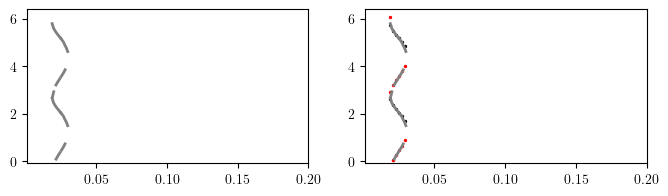

In [99]:
fig,axs = plt.subplots(1,2,figsize=(8,2))
kw_diagram = dict(a=a,b=b,eps_tup=etup,rhs=_redu_c2)
add_diagram_1d_scatter(axs[0],miter=1,**kw_diagram)
add_diagram_1d_scatter(axs[1],miter=2,**kw_diagram)

for i in range(2):
    draw_quick_plot_f(axs[i],data_bs_list,a)
    draw_quick_plot_f(axs[i],data_bu_list,a,ls='--')

#### Monodromys min

In [100]:
# get min eps
es_min,phi0 = get_es_min(data_bs_list,data_bu_list)


eigenvalues_temp = []
es_min_temp = []
for i in range(5):
    ee = es_min+0.0005*i
    m1 = get_monodromy_full(ee,phi0[-1],a,b,mname=mname_list[i].format(b))
    eigenvalues_temp.append(m1.eigenvalues)
    es_min_temp.append(ee)

b_min_all.append(b)
eigenvalues_min_all.append(eigenvalues_temp)
e_vals_mono_min.append(es_min_temp)
#m1b = get_monodromy_full(es_min+.005,phi0[-1],a,b,mname=mname2.format(b))
# m1c = get_monodromy_full(es_min+.02,phi0[-1],a,b,mname=mname3.format(b))
#

#print(m1.eigenvalues)
#print(m1b.eigenvalues)

es_min,phi0 0.018999999999999996 2.644504572434867
phi init 2.644504572434867
Y [-0.10718383  0.2326428   0.09257449  0.39831632 -0.22725448  0.08263409  0.091512    0.49854221  6.25315686]
mkdir ./data/thal2_32_b0=-0.02/
* Loading LC data...
self.T 6.253156865313874
loaded coupling expansions
* Loading monodromy...
* Floquet Exponent kappa = -0.0006352764110738613
es_min,phi0 0.019499999999999997 2.644504572434867
phi init 2.644504572434867
Y [-1.07928435e-01  2.36307789e-01  9.25567562e-02  3.93639592e-01 -4.96039306e-01  6.41908775e-01  9.71707890e-02  1.07384956e-04  6.25246972e+00]
mkdir ./data/thal2_32_b1=-0.02/
* Loading LC data...
self.T 6.252469731382957
loaded coupling expansions
* Loading monodromy...
* Floquet Exponent kappa = -0.0016396881100100244
es_min,phi0 0.019999999999999997 2.644504572434867
phi init 2.644504572434867
Y [-1.08025990e-01  2.17922965e-01  9.24238921e-02  4.15119099e-01 -4.91523700e-01  6.44465996e-01  9.69875566e-02  9.48914009e-05  6.25179243e+00]
mk

#### Monodromys max

In [101]:
# get min eps
es_max,phi0 = get_es_max(data_bs_list,data_bu_list)


eigenvalues_temp = []
es_max_temp = []
for i in range(5):
    ee = es_max-0.0005*i
    m1 = get_monodromy_full(ee,phi0[-1],a,b,mname=mname_list[i].format(b))
    eigenvalues_temp.append(m1.eigenvalues)
    es_max_temp.append(ee)

b_max_all.append(b)
eigenvalues_max_all.append(eigenvalues_temp)
e_vals_mono_max.append(es_max_temp)
#m1b = get_monodromy_full(es_max+.005,phi0[-1],a,b,mname=mname2.format(b))
# m1c = get_monodromy_full(es_max+.02,phi0[-1],a,b,mname=mname3.format(b))
#

#print(m1.eigenvalues)
#print(m1b.eigenvalues)

es_min,phi0 0.029990000000000003 1.4931776657707978
phi init 1.4931776657707978
Y [-0.10825566  0.23812291  0.09090075  0.3911042  -0.54601726  0.13607216  0.08858988  0.11443198  6.24118064]
mkdir ./data/thal2_32_b0=-0.02/
* Loading LC data...
self.T 6.253156865313874
loaded coupling expansions
* Loading monodromy...
* Floquet Exponent kappa = -0.0006352764110738613
es_min,phi0 0.029490000000000002 1.4931776657707978
phi init 1.4931776657707978
Y [-0.10814404  0.21744248  0.09090198  0.41547538 -0.5358151   0.12881326  0.08871818  0.12438338  6.24137965]
mkdir ./data/thal2_32_b1=-0.02/
* Loading LC data...
self.T 6.252469731382957
loaded coupling expansions
* Loading monodromy...
* Floquet Exponent kappa = -0.0016396881100100244
es_min,phi0 0.028990000000000002 1.4931776657707978
phi init 1.4931776657707978
Y [-0.10779523  0.23406527  0.09104999  0.39623599 -0.52031407  0.11929718  0.0888693   0.13975114  6.2416865 ]
mkdir ./data/thal2_32_b2=-0.02/
* Loading LC data...
self.T 6.251792

In [102]:
b_vals_full.append(b)

es = get_smallest_eps(data_bs_list)
eu = get_smallest_eps(data_bu_list)

e_vals_full.append(np.min([es,eu]))

es = get_largest_eps(data_bs_list)
eu = get_largest_eps(data_bu_list)

e_hi_full.append(np.max([es,eu]))

### b=-0.04

#### Branches eps stable

In [103]:
b=-.04
kw_b['recompute'] = False
kw_b['b'] = b

In [104]:
# in_dicts = [dict(phi0=phi0,eps_init=0.1,eps_final=0,deps=-.01) for phi0 in np.linspace(0,2*np.pi,20)]
in_dicts = [dict(phi0=2,eps_init=0.012,eps_final=0,deps=-.0001),
            dict(phi0=2,eps_init=0.01199,eps_final=0.2,deps=.0001)]

In [105]:
data_bs_list = []
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat = follow_phase_diffs(**in1,**kw_b)
    data_bs_list.append(dat)

phi init 2
phi init 2


In [106]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts),4])
for i in range(len(in_dicts)):
    hyp_inputs[i,0] = in_dicts[i]['phi0']
    hyp_inputs[i,1] = in_dicts[i]['eps_init']
    hyp_inputs[i,2] = in_dicts[i]['eps_final']
    hyp_inputs[i,3] = in_dicts[i]['deps']
np.savetxt(fname_bs.format(b),hyp_inputs)

#### Branches eps unstable

In [107]:
kw_b['recompute'] = False

In [108]:
kw_b['b'] = -0.019
da,Yinit = follow_phase_diffs_u(**dict(phi0=3.5,eps_init=0.025,eps_final=0,deps=-2),tol=1e-6,return_point=True,**kw_b)
print(da)
kw_b['b'] = -0.02
da,Yinit = follow_phase_diffs_u(**dict(phi0=3.5,eps_init=0.02,eps_final=0,deps=-2),tol=1e-6,use_point=Yinit,return_point=True,**kw_b)
print(da)
kw_b['b'] = -0.022
da,Yinit = follow_phase_diffs_u(**dict(phi0=3.5,eps_init=0.02,eps_final=0,deps=-2),tol=1e-6,use_point=Yinit,return_point=True,**kw_b)
print(da)
kw_b['b'] = -0.025
da,Yinit = follow_phase_diffs_u(**dict(phi0=3.5,eps_init=0.02,eps_final=0,deps=-2),tol=1e-6,use_point=Yinit,return_point=True,**kw_b)
print(da)
kw_b['b'] = -0.03
da,Yinit = follow_phase_diffs_u(**dict(phi0=3.5,eps_init=0.015,eps_final=0,deps=-2),tol=1e-6,use_point=Yinit,return_point=True,**kw_b)
print(da)
kw_b['b'] = -0.035
da,Yinit = follow_phase_diffs_u(**dict(phi0=3.5,eps_init=0.015,eps_final=0,deps=-2),tol=1e-6,use_point=Yinit,return_point=True,**kw_b)
print(da)
kw_b['b'] = -0.04
da,Yinit = follow_phase_diffs_u(**dict(phi0=3.5,eps_init=0.012,eps_final=0,deps=-2),tol=1e-6,use_point=Yinit,return_point=True,**kw_b)
print(da)

phi init 3.5
phase_diffs_u_init=3.5_nm=32_b=-0.019_ei=0.025_ef=0_de=-2.txt
phase_diffs_u_pt_init=3.5_nm=32_b=-0.019_ei=0.025_ef=0_de=-2.txt
[0.025      2.08214172 2.08214172 3.41137209 0.28909251]
phi init 3.5
phase_diffs_u_init=3.5_nm=32_b=-0.02_ei=0.02_ef=0_de=-2.txt
phase_diffs_u_pt_init=3.5_nm=32_b=-0.02_ei=0.02_ef=0_de=-2.txt
[0.02       2.08394173 2.08394173 6.15896481 3.00862848]
phi init 3.5
phase_diffs_u_init=3.5_nm=32_b=-0.022_ei=0.02_ef=0_de=-2.txt
phase_diffs_u_pt_init=3.5_nm=32_b=-0.022_ei=0.02_ef=0_de=-2.txt
[0.02       2.08420839 2.08420839 3.21304045 0.08320503]
phi init 3.5
phase_diffs_u_init=3.5_nm=32_b=-0.025_ei=0.02_ef=0_de=-2.txt
phase_diffs_u_pt_init=3.5_nm=32_b=-0.025_ei=0.02_ef=0_de=-2.txt
[0.02       2.08467506 2.08467506 3.53341265 0.4074928 ]
phi init 3.5
phase_diffs_u_init=3.5_nm=32_b=-0.03_ei=0.015_ef=0_de=-2.txt
phase_diffs_u_pt_init=3.5_nm=32_b=-0.03_ei=0.015_ef=0_de=-2.txt
[0.015      2.08667507 2.08667507 3.1753171  0.04215556]
phi init 3.5
phase_diffs_

In [109]:
kw_b['b'] = b

In [110]:
in_dicts = [
    dict(phi0=3.5,eps_init=0.012,eps_final=0,deps=-.0001),
    dict(phi0=3.5,eps_init=0.01199,eps_final=0.2,deps=.0001),
]

In [111]:
data_bu_list = []
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat = follow_phase_diffs_u(use_point=Yinit,**in1,**kw_b)
    data_bu_list.append(dat)

phi init 3.5
phase_diffs_u_init=3.5_nm=32_b=-0.04_ei=0.012_ef=0_de=-0.0001.txt
phase_diffs_u_pt_init=3.5_nm=32_b=-0.04_ei=0.012_ef=0_de=-0.0001.txt
phi init 3.5
phase_diffs_u_init=3.5_nm=32_b=-0.04_ei=0.01199_ef=0.2_de=0.0001.txt
phase_diffs_u_pt_init=3.5_nm=32_b=-0.04_ei=0.01199_ef=0.2_de=0.0001.txt


In [112]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts),4])
for i in range(len(in_dicts)):
    hyp_inputs[i,0] = in_dicts[i]['phi0']
    hyp_inputs[i,1] = in_dicts[i]['eps_init']
    hyp_inputs[i,2] = in_dicts[i]['eps_final']
    hyp_inputs[i,3] = in_dicts[i]['deps']
np.savetxt(fname_bu.format(b),hyp_inputs)

#### Plot combined 1 par

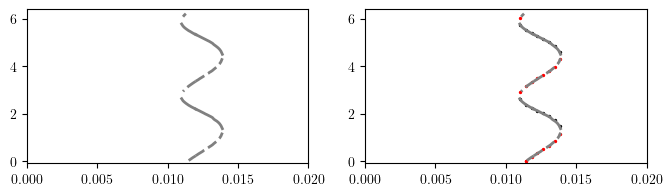

In [113]:
fig,axs = plt.subplots(1,2,figsize=(8,2))
kw_diagram = dict(a=a,b=b,eps_tup=(0,.02,50),rhs=_redu_c2)
add_diagram_1d_scatter(axs[0],miter=1,**kw_diagram)
add_diagram_1d_scatter(axs[1],miter=2,**kw_diagram)

for i in range(2):
    draw_quick_plot_f(axs[i],data_bs_list,a)
    draw_quick_plot_f(axs[i],data_bu_list,a,ls='--')

#### Monodromys min

In [114]:
# get min eps
es_min,phi0 = get_es_min(data_bs_list,data_bu_list)


eigenvalues_temp = []
es_min_temp = []
for i in range(5):
    ee = es_min+0.0005*i
    m1 = get_monodromy_full(ee,phi0[-1],a,b,mname=mname_list[i].format(b))
    eigenvalues_temp.append(m1.eigenvalues)
    es_min_temp.append(ee)

b_min_all.append(b)
eigenvalues_min_all.append(eigenvalues_temp)
e_vals_mono_min.append(es_min_temp)
#m1b = get_monodromy_full(es_min+.005,phi0[-1],a,b,mname=mname2.format(b))
# m1c = get_monodromy_full(es_min+.02,phi0[-1],a,b,mname=mname3.format(b))
#

#print(m1.eigenvalues)
#print(m1b.eigenvalues)

es_min,phi0 0.011000000000000006 2.627185685415027
phi init 2.627185685415027
Y [-0.10738292  0.2358059   0.09312547  0.39462958 -0.2324949   0.08106669  0.09201804  0.4902422   6.26568143]
mkdir ./data/thal2_32_b0=-0.04/
* Loading LC data...
self.T 6.265681435128251
loaded coupling expansions
* Loading monodromy...
* Floquet Exponent kappa = -0.0004875451374841855
es_min,phi0 0.011500000000000007 2.627185685415027
phi init 2.627185685415027
Y [-0.10734125  0.23537971  0.09298421  0.39521036 -0.3367458   0.07381031  0.09141051  0.33949902  6.26511679]
mkdir ./data/thal2_32_b1=-0.04/
* Loading LC data...
self.T 6.265116794698257
loaded coupling expansions
* Loading monodromy...
* Floquet Exponent kappa = -0.0017672113644198431
es_min,phi0 0.012000000000000007 2.627185685415027
phi init 2.627185685415027
Y [-1.07849958e-01  2.39964502e-01  9.29934231e-02  3.89595660e-01 -4.79748845e-01  6.50793122e-01  9.71293855e-02  6.88816377e-05  6.26460047e+00]
mkdir ./data/thal2_32_b2=-0.04/
* Load

#### Monodromys max

In [115]:
# get min eps
es_max,phi0 = get_es_max(data_bs_list,data_bu_list)


eigenvalues_temp = []
es_max_temp = []
for i in range(5):
    ee = es_max-0.0005*i
    m1 = get_monodromy_full(ee,phi0[-1],a,b,mname=mname_list[i].format(b))
    eigenvalues_temp.append(m1.eigenvalues)
    es_max_temp.append(ee)

b_max_all.append(b)
eigenvalues_max_all.append(eigenvalues_temp)
e_vals_mono_max.append(es_max_temp)
#m1b = get_monodromy_full(es_max+.005,phi0[-1],a,b,mname=mname2.format(b))
# m1c = get_monodromy_full(es_max+.02,phi0[-1],a,b,mname=mname3.format(b))
#

#print(m1.eigenvalues)
#print(m1b.eigenvalues)

es_min,phi0 0.01388999999999999 1.3661715179403444
phi init 1.3661715179403444
Y [-1.07649700e-01  2.38271072e-01  9.26397585e-02  3.91763244e-01 -4.32431601e-01  6.59157817e-01  9.52404130e-02  2.36195741e-05  6.26379181e+00]
mkdir ./data/thal2_32_b0=-0.04/
* Loading LC data...
self.T 6.265681435128251
loaded coupling expansions
* Loading monodromy...
* Floquet Exponent kappa = -0.0004875451374841855
es_min,phi0 0.013389999999999989 1.3661715179403444
phi init 1.3661715179403444
Y [-1.07467311e-01  2.30387727e-01  9.27110377e-02  4.01001452e-01 -4.55192166e-01  6.57995401e-01  9.60784691e-02  3.76420034e-05  6.26358959e+00]
mkdir ./data/thal2_32_b1=-0.04/
* Loading LC data...
self.T 6.265116794698257
loaded coupling expansions
* Loading monodromy...
* Floquet Exponent kappa = -0.0017672113644198431
es_min,phi0 0.012889999999999988 1.3661715179403444
phi init 1.3661715179403444
Y [-1.07628595e-01  2.20928292e-01  9.27705022e-02  4.11949114e-01 -4.64687165e-01  6.55989228e-01  9.6494837

In [116]:
b_vals_full.append(b)

es = get_smallest_eps(data_bs_list)
eu = get_smallest_eps(data_bu_list)

e_vals_full.append(np.min([es,eu]))

es = get_largest_eps(data_bs_list)
eu = get_largest_eps(data_bu_list)

e_hi_full.append(np.max([es,eu]))

# Two parameter full

In [117]:
# fname_raw = 'thal2r_{}{}_2par_fixed.dat'
# data = np.loadtxt('../bifdat_2par/'+fname_raw.format(a._n[1],a._m[1]))

fname_raw = 'thal2_{}{}_2k_o2_pos.dat'
data = np.loadtxt('../v2_bifdat_2par/redu/'+fname_raw.format(a._n[1],a._m[1]))

fname_raw = 'thal2_{}{}_2k_o2_neg.dat'
data2 = np.loadtxt('../v2_bifdat_2par/redu/'+fname_raw.format(a._n[1],a._m[1]))

fname_raw = 'thal2_{}{}_2k_o2_neg2.dat'
data3 = np.loadtxt('../v2_bifdat_2par/redu/'+fname_raw.format(a._n[1],a._m[1]))

# fname_raw = 'thal2_{}{}_o2_neg3.dat'
# data4 = np.loadtxt('../v2_bifdat_2par/redu/'+fname_raw.format(a._n[1],a._m[1]))

(-0.04, 0.02)

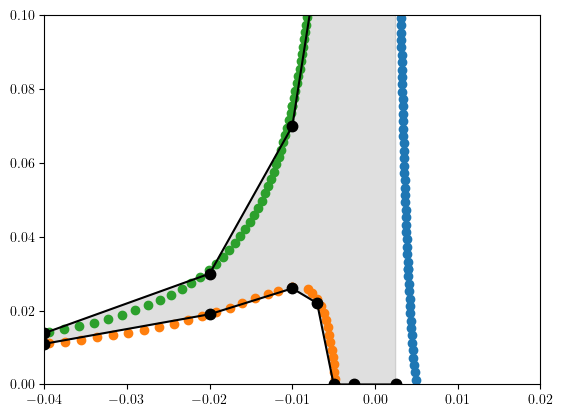

In [118]:
fig,axs = plt.subplots()
axs.fill_between(b_vals_full,e_vals_full,e_hi_full,color='gray',alpha=.25)
axs.plot(b_vals_full,e_vals_full,marker='.',color='k',markersize=15)
axs.plot(b_vals_full,e_hi_full,marker='.',color='k',markersize=15)

axs.scatter(data[:,1],data[:,0])
axs.scatter(data2[:,1],data2[:,0])
axs.scatter(data3[:,1],data3[:,0])

axs.set_ylim(0,.1)
axs.set_xlim(-.04,.02)

In [119]:
fname_lo = '../v2_bifdat_2par/full/thal2_2par_lo_{}{}.dat'.format(a._n[1],a._m[1])
fname_hi = '../v2_bifdat_2par/full/thal2_2par_hi_{}{}.dat'.format(a._n[1],a._m[1])

arr_lo = np.zeros([len(b_vals_full),2])
arr_hi = np.zeros([len(b_vals_full),2])

arr_lo[:,0] = b_vals_full
arr_lo[:,1] = e_vals_full

arr_hi[:,0] = b_vals_full
arr_hi[:,1] = e_hi_full

np.savetxt(fname_lo,arr_lo)
np.savetxt(fname_hi,arr_hi)

# Eigenvalue Convergence Plot

## Min

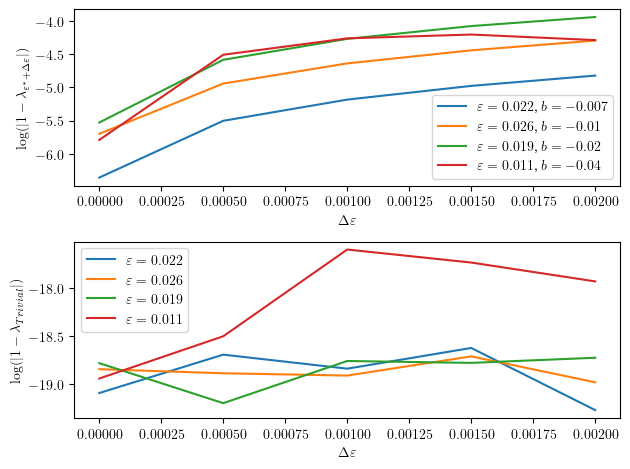

In [120]:
fig,axs = plt.subplots(2,1)

eps_values = np.arange(0,+0.0005*5,.0005)
skipn = 1

for j in range(len(eigenvalues_min_all[::skipn])):
    nn = len(eigenvalues_min_all[::skipn][j])

    at_eigen = []
    near_eigen = []
    
    for i in range(nn):
        eigenval = np.array(eigenvalues_min_all[::skipn][j][i])
        
        min1 = np.argsort(np.abs(eigenval-1))[:2]
        periodic1,bif1 = eigenval[min1]
        
        at_eigen.append(periodic1)
        near_eigen.append(bif1)

    
    ee = e_vals_mono_min[::skipn][j]
    e0 = ee[0]
    de = ee - e0
    
    axs[0].plot(eps_values,np.log(np.abs(1-np.array(near_eigen))),label=r'$\varepsilon='+str(np.round(e0,3))+r'$, ' +r'$b='+str(b_min_all[j])+r'$')
    axs[1].plot(eps_values,np.log(np.abs(1-np.array(at_eigen))),label=r'$\varepsilon='+str(np.round(e0,3))+r'$')
    #axs[1].plot(lc_list2,label='Near Bifurcation')

    axs[0].legend()
    axs[1].legend()

    axs[0].set_xlabel(r'$\Delta\varepsilon$')
    axs[1].set_xlabel(r'$\Delta\varepsilon$')
    #axs[1].set_xlabel('Point')
    
    axs[0].set_ylabel(r'$\log(|1 - \lambda_{\varepsilon^*+\Delta\varepsilon}|)$')
    axs[1].set_ylabel(r'$\log(|1-\lambda_{Trivial}|)$')

    plt.tight_layout()
    plt.savefig('../figs/supp_convergence_thal2_min_{}{}.png'.format(a._n[1],a._m[1]))

## Max

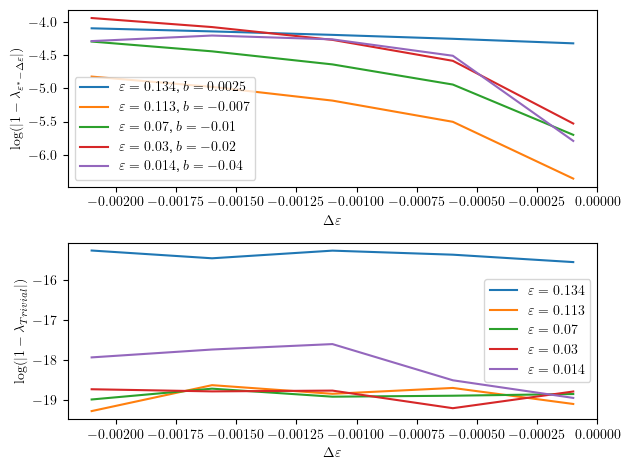

In [121]:
fig,axs = plt.subplots(2,1)

#es_min+.0001+0.0005*i
#ee = es_max-.0001-0.0005*i
eps_values = np.arange(-0.0001,0.0001-0.0005*5,-.0005)
skipn = 1

for j in range(len(eigenvalues_max_all[::skipn])):
    nn = len(eigenvalues_max_all[::skipn][j])

    at_eigen = []
    near_eigen = []
    
    for i in range(nn):
        eigenval = np.array(eigenvalues_max_all[::skipn][j][i])
        
        max1 = np.argsort(np.abs(eigenval-1))[:2]
        periodic1,bif1 = eigenval[max1]
        
        at_eigen.append(periodic1)
        near_eigen.append(bif1)

    ee = e_vals_mono_max[::skipn][j]
    e0 = ee[0]
    de = ee - e0
    
    axs[0].plot(eps_values,np.log(np.abs(1-np.array(near_eigen))),label=r'$\varepsilon='+str(np.round(e0,3))+r'$, ' +r'$b='+str(b_max_all[j])+r'$')
    axs[1].plot(eps_values,np.log(np.abs(1-np.array(at_eigen))),label=r'$\varepsilon='+str(np.round(e0,3))+r'$')
    #axs[1].plot(lc_list2,label='Near Bifurcation')

    axs[0].legend()
    axs[1].legend()

    axs[0].set_xlabel(r'$\Delta\varepsilon$')
    axs[1].set_xlabel(r'$\Delta\varepsilon$')
    #axs[1].set_xlabel('Point')
    
    axs[0].set_ylabel(r'$\log(|1 - \lambda_{\varepsilon^*-\Delta\varepsilon}|)$')
    axs[1].set_ylabel(r'$\log(|1-\lambda_{Trivial}|)$')

    plt.tight_layout()
    plt.savefig('../figs/supp_convergence_thal2_max_{}{}.png'.format(a._n[1],a._m[1]))